In [ ]:
! pip install \
  scprep\
  spacy==2.3.2 \
  sentence_transformers==0.4.0 \
  phate==1.0.4 && \
  python -m spacy download es_core_news_lg

<span style="color:red"><strong>WARNING!</strong></span> Once you installed the packages in the previous cell you must restart your runtime and then import the library and load the model

In [ ]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [ ]:
!rm -rf policy-data-analyzer/

In [ ]:
# Define branch to clone
! branch_name='#50_dfq_sbert_fine_tuning' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (319/319), done.
remote: Total 2900 (delta 318), reused 337 (delta 178), pack-reused 2402
Receiving objects: 100% (2900/2900), 126.76 MiB | 26.37 MiB/s, done.
Resolving deltas: 100% (1476/1476), done.
Checking out files: 100% (843/843), done.


In [ ]:
import pandas as pd
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from typing import Iterable, Dict
from torch.utils.data import DataLoader
import math
import time
import cupy as cp

# os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loader.src.utils import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.evaluate_model.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Fine tune SBERT on Binary Classification

Similar setup for fine tuning multi-class. Maybe we should have this section in the other notebook, and in this one we just load the model? 


In [ ]:
class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network. 
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """
    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']
        
        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output

### Load data
For now, EXP9 will be binary classification

In [ ]:
rater = "Rater3" # TODO: Change accordingly to what is the dataset you want to analyze
Experiment = "EXP9" 

# This first one is the one used by David and Daniel
path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/datasets/"
# This one is the one used by Jordi
# path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Cristina_Policy_Files/Tagged_sentence_lists/datasets/"

model_names = ['stsb-xlm-r-multilingual', 'paraphrase-xlm-r-multilingual-v1']#, 'quora-distilbert-multilingual''distiluse-base-multilingual-cased-v2', 

In [ ]:
filename = "dataset_" + rater + "_incentive_sentences.csv"
file = path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    all_sents = list(reader)[0]

filename = "dataset_" + rater + "_incentive_labels.csv"
file = path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    all_labels = list(reader)[0]

filename = "testset_" + rater + "_incentive_sentences.csv"
file = path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    test_sents = list(reader)[0]

filename = "testset_" + rater + "_incentive_labels.csv"
file = path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    test_labels = list(reader)[0]

label_names = unique_labels(all_labels)
numeric_labels = labels2numeric(all_labels, label_names)
label_names

['not_Incentive', 'Incentive']

In [ ]:
all_sents[2], all_labels[2], test_sents[2], test_labels[2]

('El pago de los recibos se hara en todo caso correlativamente, no siendo admisible el pago de uno de ellos dejando pendiente el anterior o anteriores',
 'not_Incentive',
 'Facilitar el acceso a mercados, servicios financieros, programas y proyectos.',
 'Incentive')

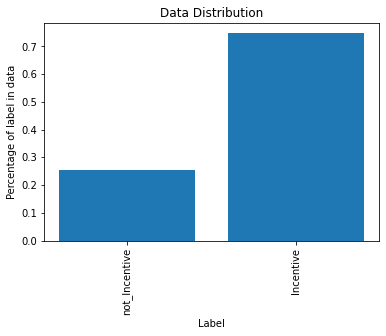

Label counts:
{'not_Incentive': 0.2532786885245902, 'Incentive': 0.7467213114754099}


In [ ]:
plot_data_distribution(numeric_labels, label_names)

As we can see, we have 3/4 of the data as Incentives and 1/4 as Non-incentives. Hopefully our model will be able to differentiate!

### Replicate Fine Tuning from Multi Class

However, for time purposes, we will use the minimum number of parameters necessary so we can get to the binary classification setup part! When actually fine tuning, we should explore more hyperparameters. Things to change when running full:
- Add more test/validation data percentages in `all_test_perc`
- Include more models in `model_names`
- Comment out `num_epochs=10`, replace parameter `epochs` in `model.fit()` to be 2, uncomment `max_num_epochs` and uncomment for loop that iterates through epochs. 
- Comment out the parameter `output_path` in `model.fit()`
- **IMPORTANT:** Since we don't store the models during normal training, we should create the directory in which the confusion matrix and t-SNE plots should be written to

In [ ]:
# Train test split stratified
all_test_perc = [0.2]
model_names = ['paraphrase-xlm-r-multilingual-v1']#, 'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual', 'distiluse-base-multilingual-cased-v2', 

# Output setup
output = {}

for test_perc in all_test_perc:
  output[f"test_perc={test_perc}"] = {}
  X_train, X_test, y_train, y_test = train_test_split(all_sents, all_labels, test_size=test_perc, stratify=all_labels, random_state=69420)

  # Load data samples into batches
  train_batch_size = 16
  label2int = dict(zip(label_names, range(len(label_names))))
  train_samples = []
  for sent, label in zip(X_train, y_train):
      label_id = label2int[label]
      train_samples.append(InputExample(texts=[sent], label=label_id))

  # Configure the dev set evaluator - still need to test whether this works
  dev_samples = []
  for sent, label in zip(X_test, y_test):
      label_id = label2int[label]
      dev_samples.append(InputExample(texts=[sent], label=label_id))
  
  for model_name in model_names:
    # Setup
    model_preds = []
    model_scores = []
    output[f"test_perc={test_perc}"][model_name] = []
    
    # Train set config
    model = SentenceTransformer(model_name)
    train_dataset = SentencesDataset(train_samples, model=model)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
    
    # Define the way the loss is computed
    classifier = SoftmaxClassifier(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(label2int))
    
    # Dev set config
    dev_dataset = SentencesDataset(dev_samples, model=model)
    dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
    dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')

    # Configure the training
    # max_num_epochs = 10
    num_epochs = 10 # For now we will make the model train straight up to 10 epochs
    
    # for num_epochs in range(4, max_num_epochs + 2, 2):
    print("Num epochs:", num_epochs)
    
    warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
    model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"
  
    model_save_path = f"/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/BinaryFineTuning_{model_deets}"
    # model_save_path = f"/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/FineTuning_{model_deets}"
    

    # Train the model
    start = time.time()

    # WARNING: epochs should be changed to 2 when testing multiple epochs... or maybe we should have another variable for it
    model.fit(train_objectives=[(train_dataloader, classifier)],
              evaluator=dev_evaluator,
              epochs=num_epochs, # We always tune on an extra epoch to see the performance gain
              evaluation_steps=1000,
              warmup_steps=warmup_steps,
              output_path=model_save_path
              )
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    
    ### Classify sentences
    # Projection matrix Z low-dim projection
    print("Classifying sentences...")
    proj_matrix = cp.asnumpy(calc_proj_matrix(test_sents, 50, es_nlp, model, 0.01))
    all_sent_embs = encode_all_sents(test_sents, model, proj_matrix)
    all_label_embs = encode_labels(label_names, model, proj_matrix)
    visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50, store_name=f"{model_save_path}/{model_deets}")
    model_preds, model_scores = calc_all_cos_similarity(all_sent_embs, all_label_embs, label_names)
    
    ### Evaluate the model
    numeric_preds = labels2numeric(model_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
    
    output[f"test_perc={test_perc}"][model_name].append({"num_epochs": num_epochs, "avg_f1": evaluator.avg_f1.tolist()})
    
    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{model_save_path}/{model_deets}")

In [ ]:
new_json = {}

for key in output.keys():
  new_json[key] = {}
  for subkey in output[key].keys():
    new_json[key][subkey] = []
    for element in output[key][subkey]:
      el_copy = {"avg_f1": element["avg_f1"], "num_epochs": element["num_epochs"]}
      new_json[key][subkey].append(el_copy)

In [ ]:
import json
output_path = f"/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/"
# output_path = f"/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/"
with open(f"{output_path}{Experiment}_FineTuningResults.json", "w") as f:
  json.dump(new_json, f)

## 2. Load fine-tuned model and use embeddings to train a binary classifier

### Load model

In [ ]:
model_name = "paraphrase-xlm-r-multilingual-v1"
test_perc = 0.2
num_epochs = 10
model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"
experiment = "EXP9"
saved_model_path = f"/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{experiment}/BinaryFineTuning_{model_deets}"
# saved_model_path = f"/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/FineTuning_{model_deets}"

In [ ]:
bin_model = SentenceTransformer(saved_model_path)

### Encode Sentences

First, we will check how good are the fine tuned embeddings without the projection matrix addition

In [ ]:
all_sent_embs = encode_all_sents(test_sents, bin_model)

100%|██████████| 306/306 [00:05<00:00, 54.29it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 306 samples in 0.033s...
[t-SNE] Computed neighbors for 306 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 306 / 306
[t-SNE] Mean sigma: 2.491708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.511703
[t-SNE] KL divergence after 1000 iterations: 0.449039


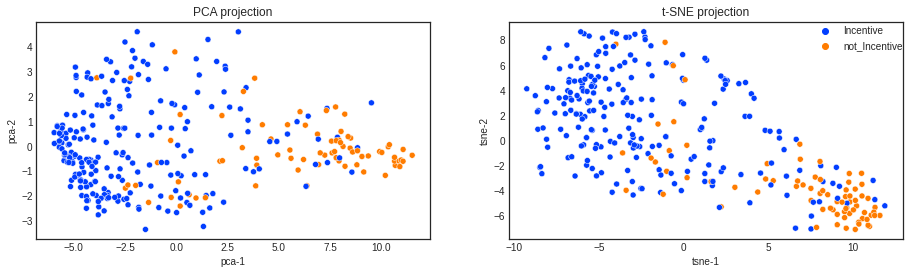

In [ ]:
visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50)

Ok, doesn't look that bad, but not perfect either... The incentives are scattered too much in the space, and the line between non-incentives and incentives is not clearly defined. ***For now, it doesn't matter - but we should experiment more with fine tuning.***.

Now, let's check whether the projection matrix helps:

In [ ]:
proj_matrix = cp.asnumpy(calc_proj_matrix(all_sents, 50, es_nlp, bin_model, 0.01))
all_sent_embs = encode_all_sents(test_sents, bin_model, proj_matrix)

100%|██████████| 306/306 [00:07<00:00, 40.82it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 306 samples in 0.006s...
[t-SNE] Computed neighbors for 306 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 306 / 306
[t-SNE] Mean sigma: 20.201386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.918625
[t-SNE] KL divergence after 1000 iterations: 0.734087


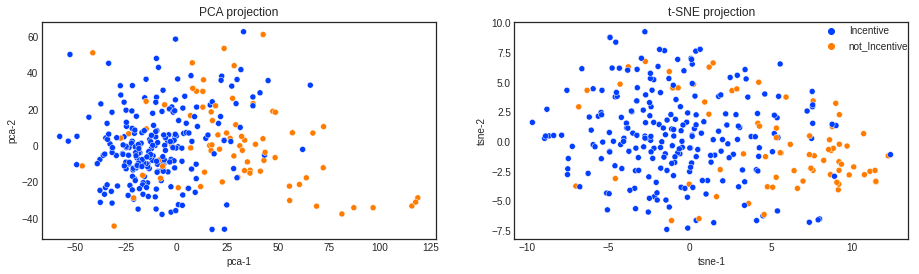

In [ ]:
visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50)

Actually, the projection matrix makes things worse. ***Let's NOT use it for now!!!!!***

In [ ]:
# Simple embeddings, no projection matrix added
all_sent_embs = encode_all_sents(all_sents, bin_model)

100%|██████████| 1220/1220 [00:22<00:00, 54.73it/s]


In [68]:
all_test_embs = encode_all_sents(test_sents, bin_model)

100%|██████████| 306/306 [00:05<00:00, 54.31it/s]


### Train classifiers

In [120]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

1. Let's start with Random Forests!

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [135]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=69420)

In [136]:
clf.fit(np.vstack(all_sent_embs), all_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69420,
                       verbose=0, warm_start=False)

In [137]:
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]

In [138]:
 print(classification_report(test_labels, clf_preds))

               precision    recall  f1-score   support

    Incentive       0.89      0.93      0.91       228
not_Incentive       0.76      0.68      0.72        78

     accuracy                           0.86       306
    macro avg       0.83      0.80      0.81       306
 weighted avg       0.86      0.86      0.86       306



In [139]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

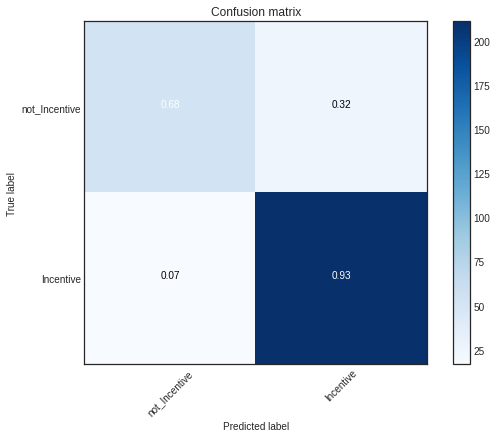

In [140]:
evaluator.plot_confusion_matrix(color_map='Blues')

Honestly, without Grid Search and 5-fold Cross Validation, these are not bad results... We should add those though!

2. Now, we're gonna try Support Vector Machines

In [99]:
from sklearn import svm

In [129]:
clf = svm.SVC(gamma=0.001, C=100.)

In [130]:
clf.fit(np.vstack(all_sent_embs), all_labels)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [131]:
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]

In [132]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

In [133]:
print(classification_report(test_labels, clf_preds))

               precision    recall  f1-score   support

    Incentive       0.91      0.92      0.92       228
not_Incentive       0.76      0.74      0.75        78

     accuracy                           0.88       306
    macro avg       0.84      0.83      0.84       306
 weighted avg       0.87      0.88      0.88       306



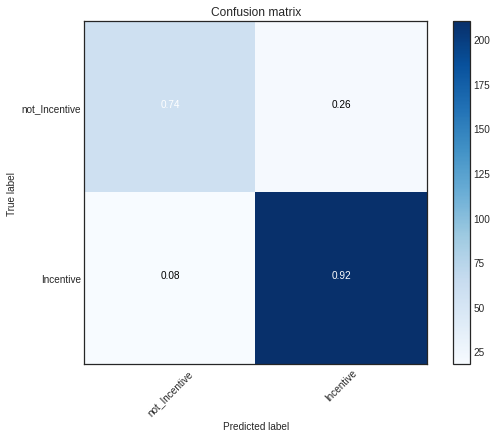

In [134]:
evaluator.plot_confusion_matrix(color_map='Blues')

Ok, so SVMs are slightly better than Random Forests at ***differentiating*** text! There's a 1-2% decrease in performance for the incentive class, but a 6% gain in non-incentives. If these results remain when doing cross validation and grid search, then I'd recommend going for the SVMs.


**Next steps:**
- Add Grid Search Cross Validation from sklearn

### What about... Beto?
I downloaded the weights and placed them in the folder below: 

In [142]:
beto_path = f"/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/BETO/pytorch/"

In [145]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

***IMPORTANT:*** I was not able to figure out a way of using the fine tuning results from the models above so I'm gonna use BETO out of the box, for both encoding/classification and see how it goes.

The following cells are a demo of how the model should be put to use - once you understand it, feel free to skip this part!

In [146]:
tokenizer = BertTokenizer.from_pretrained(beto_path)
model = BertForSequenceClassification.from_pretrained(beto_path)

Some weights of the model checkpoint at /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/BETO/pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificati

In [148]:
classes = ["no es parafrasis", "es parafrasis"]

sequence_0 = "La compañia Hugging esta basada en Nueva York"
sequence_1 = "Las manzanas son malas para la salud"
sequence_2 = "La sede principal de Hugging esta en Manhattan"

paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]

In [156]:
print(">>> Deberia de ser parafrasis:")
for i in range(len(classes)):
  print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")

print("\n>>> NO deberia de ser parafrasis:")
for i in range(len(classes)):
  print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

>>> Deberia de ser parafrasis:
no es parafrasis: 41%
es parafrasis: 59%

>>> NO deberia de ser parafrasis:
no es parafrasis: 61%
es parafrasis: 39%


OK! Now it's time to apply it to our data. We will try it out with our test set, just to have a fair comparison

In [159]:
tokenized_sents = tokenizer(test_sents, padding=True, return_tensors="pt")
clf_logits = model(**tokenized_sents).logits
clf_results = torch.softmax(clf_logits, dim=1).tolist()[0]

RuntimeError: ignored

In [ ]:
# This stores the index of the highest score - in other words, our label
clf_preds = [np.argmax(logits) for logits in clf_results]

In [ ]:
print(classification_report(test_labels, clf_preds))

In [161]:
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=clf_preds)
evaluator.plot_confusion_matrix(color_map='Blues')

1